In [1]:
import os
import requests

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/project/svd-kernels')
from src.optimizers import SVDAdam
from src.callbacks import OrthogonalityTracker, ConditioningTracker
from src.layers import SVDDense

In [3]:
plt.style.use('dark_background')

# MNIST performance benchmarking

### Data loading

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


### Visualization

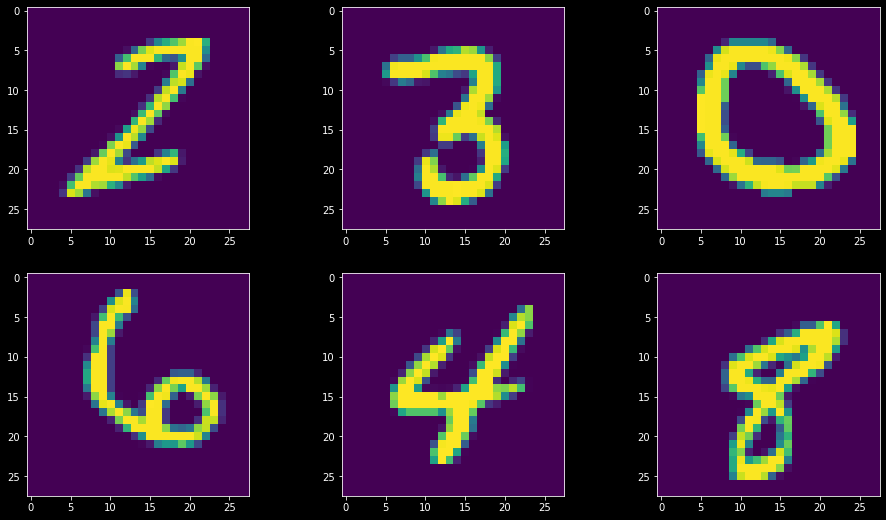

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.reshape(-1)
for ax in axes:
    ax.imshow(x_train[np.random.randint(len(x_train)), ...])
plt.show()

### Preprocessing

In [6]:
# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

### Data pipeline

In [7]:
batch_size = 32
buffer_size = batch_size * 128
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
for x, y in dataset.take(1):
    print(x.shape, y.shape)

(32, 28, 28, 1) (32,)


### Model

In [43]:
# Parameters for model architecture
units = 512
rank = 32
n_classes = 10
activation = 'elu'

In [49]:
# Make input layer
inputs = tf.keras.Input(shape=x.shape[1:])
# Convolutional layer one
hidden = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation=activation)(inputs)
# Convolutional layer two
hidden = tf.keras.layers.Conv2D(64, (3, 3), activation=activation)(hidden)
# Maximum pooling
hidden = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(hidden)
# Dropout
hidden = tf.keras.layers.Dropout(0.25)(hidden)
# Flatten
hidden = tf.keras.layers.Flatten()(hidden)
# Fully connected
hidden = tf.keras.layers.Dense(units, activation=activation)(hidden)
# Dropout
hidden = tf.keras.layers.Dropout(0.5)(hidden)
# Projection layer
outputs = tf.keras.layers.Dense(n_classes, 'softmax')(hidden)
# Make & compile model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [50]:
# Number of epochs
epochs = 5
# Learning rates
learning_rate = 10e-4
nu = 10e-4
# acceleration parameters
beta = 0.0
gamma = 0.999

# Loss and accuracy
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
accuracy_fn = tf.keras.metrics.SparseCategoricalAccuracy()

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, patience=1)

In [51]:
# SVD optimizer
optimizer = SVDAdam(model, learning_rate, nu, beta, gamma)
# Compile model
model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
# Callbacks
callbacks = [early_stopping]
# Train model
history = model.fit(dataset, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)

Epoch 1/5
1875/1875 [==============================] - 199s 106ms/step - loss: 0.2886 - sparse_categorical_accuracy: 0.9134 - val_loss: 0.0934 - val_sparse_categorical_accuracy: 0.9698
Epoch 2/5
1875/1875 [==============================] - 199s 106ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.9699 - val_loss: 0.0675 - val_sparse_categorical_accuracy: 0.9774
Epoch 3/5
1875/1875 [==============================] - 200s 106ms/step - loss: 0.0816 - sparse_categorical_accuracy: 0.9759 - val_loss: 0.0819 - val_sparse_categorical_accuracy: 0.9772
Epoch 00003: early stopping


In [52]:
# Make trackers
orthogonality_tracker = OrthogonalityTracker(on_batch=True)
conditioning_tracker = ConditioningTracker(on_batch=True)

In [53]:
# Make input layer
inputs = tf.keras.Input(shape=x.shape[1:])
# Convolutional layer one
hidden = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation=activation)(inputs)
# Convolutional layer two
hidden = tf.keras.layers.Conv2D(64, (3, 3), activation=activation)(hidden)
# Maximum pooling
hidden = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(hidden)
# Dropout
hidden = tf.keras.layers.Dropout(0.25)(hidden)
# Flatten
hidden = tf.keras.layers.Flatten()(hidden)
# Fully connected
hidden = SVDDense(units, rank, activation=activation)(hidden)
hidden = SVDDense(units, rank, activation=activation)(hidden)
hidden = SVDDense(units, rank, activation=activation)(hidden)
# Dropout
hidden = tf.keras.layers.Dropout(0.5)(hidden)
# Projection layer
outputs = tf.keras.layers.Dense(n_classes, 'softmax')(hidden)
# Make & compile model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [54]:
# SVD optimizer
optimizer = SVDAdam(model, learning_rate, nu, beta, gamma, method='chi', k=None)
# Compile model
model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
# Add trackers to callbacks
callbacks = [early_stopping]
callbacks += [orthogonality_tracker, conditioning_tracker]
# Train model
history_ = model.fit(dataset, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)

Epoch 1/5
1875/1875 [==============================] - 927s 493ms/step - loss: 0.9521 - sparse_categorical_accuracy: 0.8453 - val_loss: 0.2697 - val_sparse_categorical_accuracy: 0.9084
Epoch 2/5
 366/1875 [====>.........................] - ETA: 12:15 - loss: 0.2676 - sparse_categorical_accuracy: 0.9206

KeyboardInterrupt: 

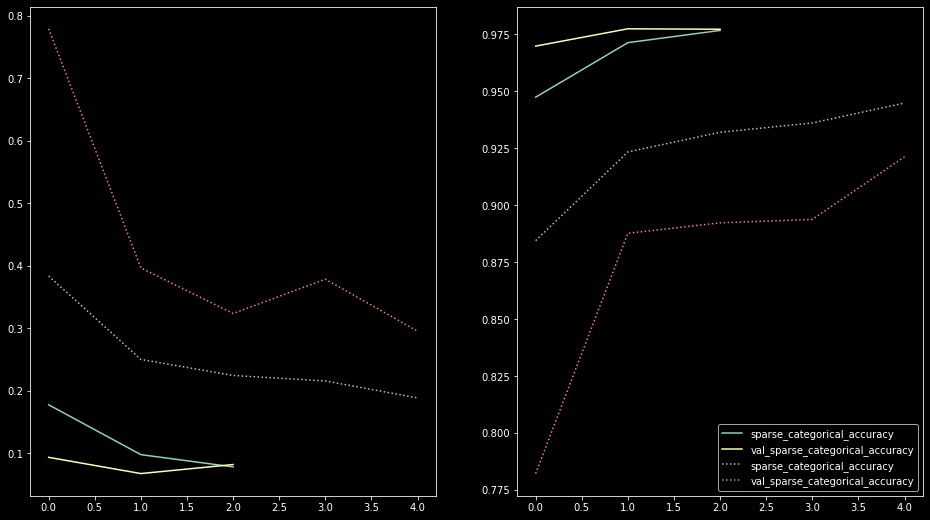

In [55]:
fig, axes = plt.subplots(1,2, figsize=(16, 9))
for key, value in history.history.items():
    i = 0 if 'loss' in key else 1
    axes[i].plot(value, label=key)
for key, value in history_.history.items():
    i = 0 if 'loss' in key else 1
    axes[i].plot(value, label=key, linestyle='dotted')
plt.legend()
plt.show()

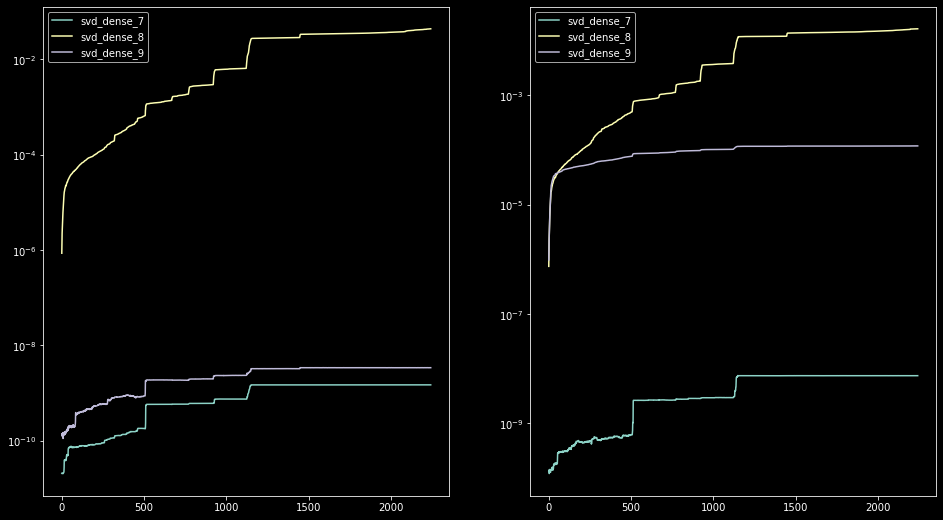

In [56]:
fig, axes = plt.subplots(1,2, figsize=(16, 9))
for layer in model.layers:
    if 'svd' in layer.name:
        axes[0].plot(orthogonality_tracker.kappa[layer.name]['u'], label=layer.name)
        axes[1].plot(orthogonality_tracker.kappa[layer.name]['v'], label=layer.name)
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].legend()
axes[1].legend()
plt.show()

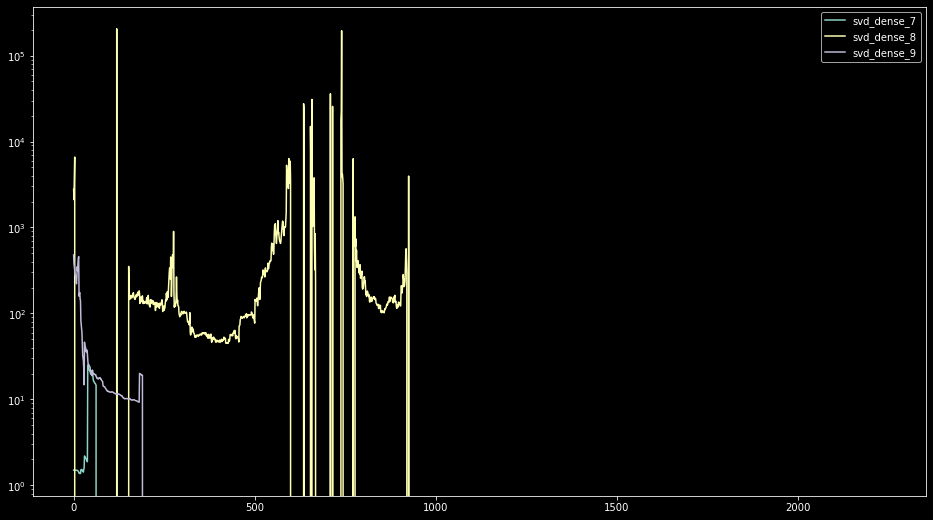

In [57]:
fig, axes = plt.subplots(1,1, figsize=(16, 9))
for layer in model.layers:
    if 'svd' in layer.name:
        plt.plot(conditioning_tracker.kappa[layer.name], label=layer.name)
plt.yscale('log')
plt.legend()
plt.show()